# Importing necessary packages and libraries

In [ ]:
!pip install spectral 
import numpy as np
import scipy
import os
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Concatenate, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
import argparse
K.image_data_format()
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import h5py
from keras.models import load_model

# Connecting to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Global values (windowSize, numPCAcomponents, testRatio) from the text file global_variables.txt

In [ ]:
myFile = open('/content/drive/My Drive/thesis/global_variables.txt', 'r') 
file = myFile.readlines()[:]

for line in file:
    if line[0:3] == "win":
        ds = line.find('=')
        windowSize = int(line[ds+1:-1],10)

    elif line[0:3] == "num":
        ds = line.find('=')
        numPCAcomponents = int(line[ds+2:-1],10)

    else:
        ds = line.find('=')
        testRatio = float(line[ds+1:])

# Function Definition

In [ ]:
def splitTrainTestSet(X, y, testRatio=0.10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
# Loading training datasets
train_X = np.load("/content/drive/My Drive/thesis/Hyperimage/Reflectance/VNIR/spatialSize/X_Patches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio)  + ".npy")
train_Y = np.load("/content/drive/My Drive/thesis/Hyperimage/Reflectance/VNIR/spatialSize/y_Patches_" + str(windowSize) + "PCA" + str(numPCAcomponents) + "testRatio" + str(testRatio) + ".npy")

#Splitting the data into train and test set
X_train, X_test, y_train, y_test = splitTrainTestSet(train_X, train_Y, testRatio)

# Reshape into (numberofsamples, channels, height, width)
train_X = np.reshape(train_X, (train_X.shape[0],train_X.shape[3], train_X.shape[1], train_X.shape[2]))

# convert class labels to on-hot encoding
train_Y = np_utils.to_categorical(train_Y)

# Reshape into (numberofsamples, channels, height, width)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[3], X_train.shape[1], X_train.shape[2]))
# convert class labels to on-hot encoding
y_train = np_utils.to_categorical(y_train)
# Reshape into (numberofsamples, channels, height, width)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[3], X_test.shape[1], X_test.shape[2]))
# convert class labels to on-hot encoding
y_test = np_utils.to_categorical(y_test)

input_shape = train_X[0].shape
C1 = 3*2

In [ ]:
# Define the model 1
def model_1():
  model = Sequential()

  model.add(Conv2D(C1, (3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(3*C1, (3, 3), activation='relu'))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(6*numPCAcomponents, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Define the model 2
def model_2():
  model = Sequential()

  model.add(Conv2D(C1, (5, 3), activation='relu', input_shape=input_shape, data_format='channels_first'))
  model.add(Conv2D(2*C1, (3, 3), activation='relu'))
  model.add(Conv2D(3*C1, (3, 3), activation='relu'))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(6*numPCAcomponents, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))
  sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Train the model and validate with test data
model = model_1()
history = model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 8, 9, 6)           600       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 7, 18)          990       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 7, 18)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 756)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                45420     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

Test loss: 1.3601796287103112e-09 / Test accuracy: 1.0


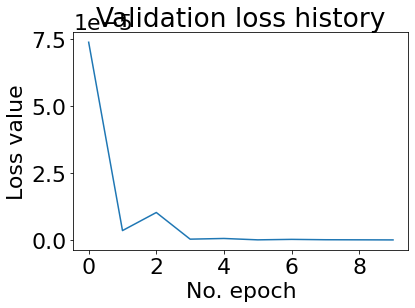

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

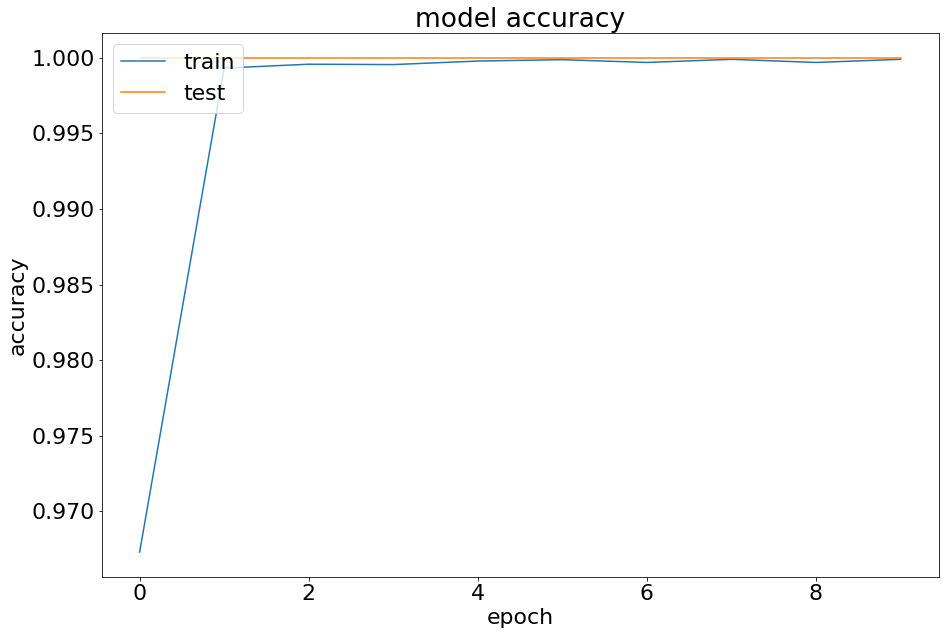

In [ ]:
# Model Accuracy plot
plt.rcParams.update({'font.size':22})
plt.figure(figsize=(15, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

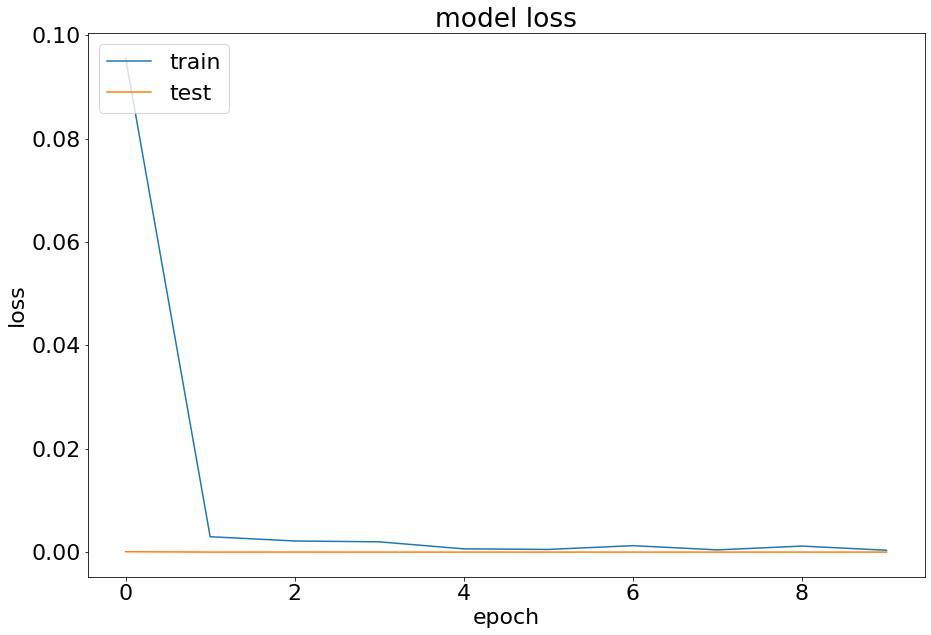

In [ ]:
# summarize history for loss
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Train the model with all training data
model.fit(train_X, train_Y, batch_size=100, epochs=20)

Epoch 1/20
53896/53896 [==============================] - 6s 105us/step - loss: 3.9044e-04 - accuracy: 0.9999
Epoch 2/20
53896/53896 [==============================] - 6s 105us/step - loss: 7.6754e-04 - accuracy: 0.9998
Epoch 3/20
53896/53896 [==============================] - 6s 104us/step - loss: 6.7176e-04 - accuracy: 0.9997
Epoch 4/20
53896/53896 [==============================] - 6s 103us/step - loss: 3.2671e-04 - accuracy: 0.9999
Epoch 5/20
53896/53896 [==============================] - 6s 105us/step - loss: 1.5101e-04 - accuracy: 1.0000
Epoch 6/20
53896/53896 [==============================] - 6s 115us/step - loss: 1.3142e-04 - accuracy: 0.9999
Epoch 7/20
53896/53896 [==============================] - 7s 122us/step - loss: 1.7210e-04 - accuracy: 0.9999
Epoch 8/20
53896/53896 [==============================] - 6s 105us/step - loss: 5.2939e-04 - accuracy: 0.9999
Epoch 9/20
53896/53896 [==============================] - 6s 105us/step - loss: 1.2163e-04 - accuracy: 0.9999
Epoch 10/2

In [ ]:
# Save the model
model.save('/content/drive/My Drive/thesis/training/my_model1_refVNIR' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')


In [ ]:
# Train second model and save the model
model1 = model_2()
history = model1.fit(train_X, train_Y, batch_size=100, epochs=10, validation_data=(X_test, y_test))
model1.save('/content/drive/My Drive/thesis/training/my_model2_rad_VNIR1' + str(windowSize) + 'PCA' + str(numPCAcomponents) + "testRatio" + str(testRatio) + '.h5')

AttributeError: ignored